# Super Resolution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 868 kB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import copy
import cv2
import os
import json
import time

from PIL import Image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from model import UNet
from dsr import DSRDataset
from pathlib import Path

from srd import SuperResolutionDataset

train_dataset = SuperResolutionDataset(data_path='flowers/train', resolution=128)
val_dataset = SuperResolutionDataset(data_path='flowers/valid', resolution=128)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True
)

In [12]:
root = Path('./dsr/')

with open(root / 'train_valid_test_split.json', 'r') as f:
    split = json.load(f)
    
train_dataset = DSRDataset(root, split['train'], resolution=128)
val_dataset = DSRDataset(root, split['test'], resolution=128)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True,
    prefetch_factor=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True,
    prefetch_factor=2
)

Loaded 5175 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', '0057', '0058', '0059', '0060', '0061', '0063', '0065', '0067', '0069', '0070', '0072', '0074', '0077', '0078', '0080', '0081', '0170', '0087', '0088', '0090', '0092', '0093', '0095', '0096', '0098', '0099', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0112', '0114', '0116', '0230', '0118', '0120', '0121', '0123', '0124', '0128', '0130', '0131', '0133', '0134', '0135', '0136', '0138', '0139', '0141', '0143', '0171', '0145', '0147', '0150', '0174', '0176', '0157', '0158', '0159', '0160', '0161', '0163', '0178', '0181', '0186', '0187', '0183', '0185', '0189', '0190', '0191', '0194', '0195', '0200', '0201', '0202', '0203', '0204', '0208', '0218', '0223'] and height None
Loaded 2532 pairs for scenes ['0175', '0169', '0154', '0030', '0180', '0228', '0214', '0229', '0151', '0055', '0071', '0225', '0153', '0102', '0156', '004

Time taken to get next batch of images: 14.213833808898926 seconds
(16, 3, 128, 128)
(16, 3, 128, 128)
mean: -0.007165935
variance: 0.12208656
min: -1.0
max: 1.0


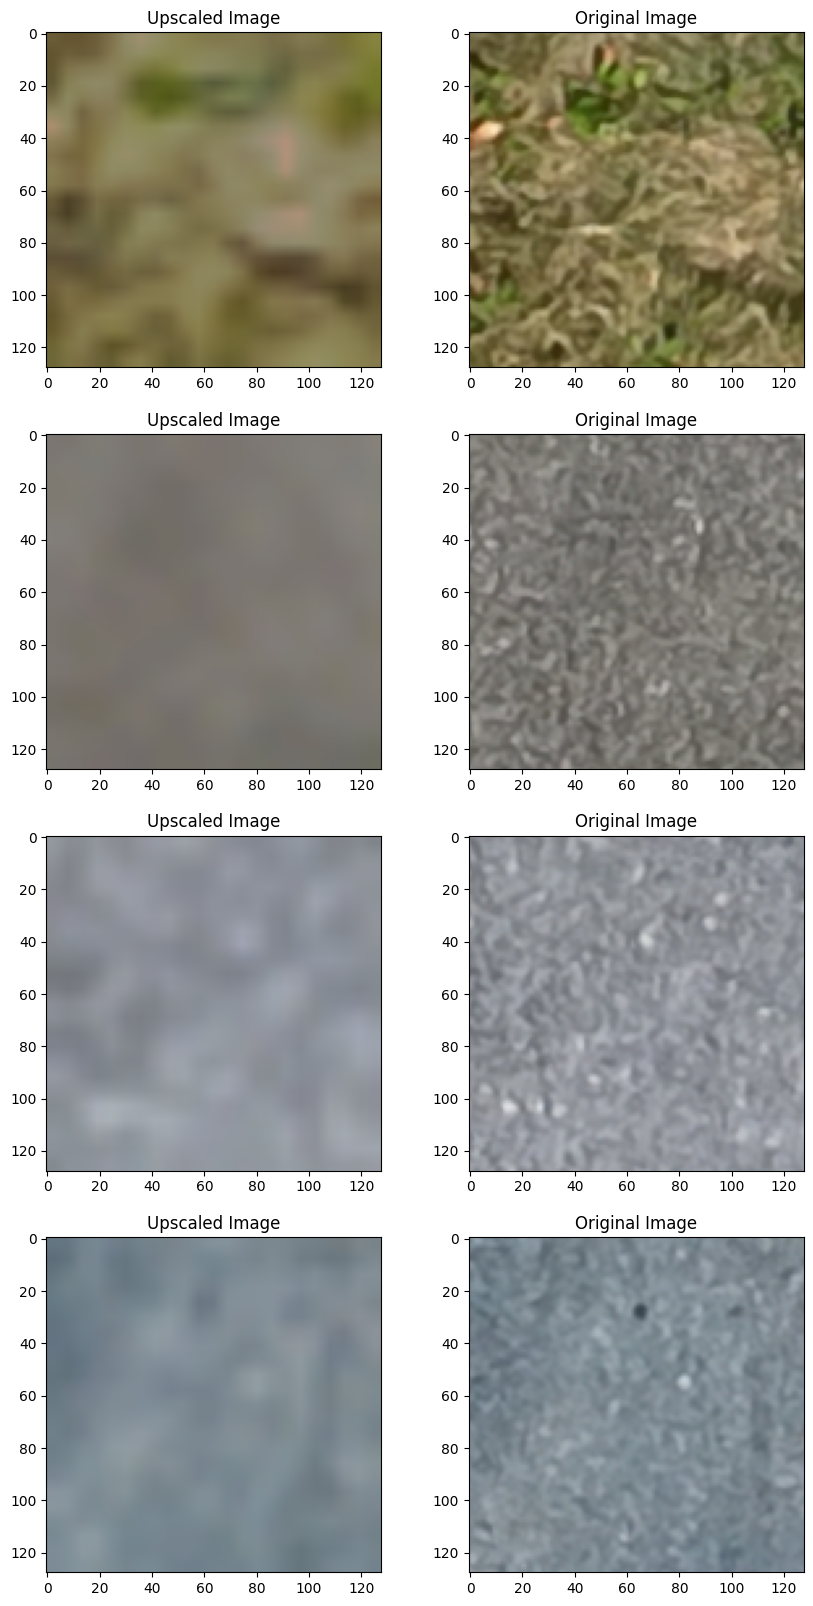

In [13]:
start_time = time.time()

images = next(iter(train_loader))
lowres_images = images[0].numpy()
highres_images = images[1].numpy()

elapsed_time = time.time() - start_time
print(f"Time taken to get next batch of images: {elapsed_time} seconds")

print(lowres_images.shape)
print(highres_images.shape)

print('mean:', highres_images.mean())
print('variance:', highres_images.var())
print('min:', highres_images.min())
print('max:', highres_images.max())

fig, axes = plt.subplots(figsize=(10, 20), nrows=4, ncols=2)
for i in range(4):
    ax = axes[i]

    lowres_image = (lowres_images[i] + 1) / 2
    highres_image = (highres_images[i] + 1) / 2

    ax[0].imshow(lowres_image.transpose(1, 2, 0))
    ax[0].set_title('Upscaled Image')

    ax[1].imshow(highres_image.transpose(1, 2, 0))
    ax[1].set_title('Original Image')

plt.show()

## U-Net

![Example Image](unet.png)

In [6]:
from simple_diffusion.model import UNet
from simple_diffusion.scheduler import DDIMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet = UNet(hidden_dims=[16, 32, 64, 128], image_size=256).to(device)
optimizer = torch.optim.AdamW(unet.parameters(),lr=1e-4,betas=(0.9, 0.99),weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # log this to tensorboard, add patience
criterion = nn.MSELoss()
epochs = 50
T = 2000
diffusion_scheduler = DDIMScheduler(beta_schedule="cosine") #DiffusionScheduler(T, schedule_type='linear')
tensorboard_path="./runs/diffusion-2M-dsr-256R-cosine-1e-4"

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print("Number of parameters:", num_params, device)

Number of parameters: 2291539 cuda


In [7]:
from train import train

train(unet, diffusion_scheduler, train_loader, val_loader, epochs, device, optimizer, scheduler, criterion, tensorboard_path, num_accumulation_steps=32)

Start training... (mixed)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Iteration 0 Loss 1.1538351774215698
Epoch 0 Iteration 50 Loss 1.0307344198226929
Epoch 0 Iteration 100 Loss 0.9736716151237488
Epoch 0 Iteration 150 Loss 0.9388022422790527
Epoch 0 Iteration 200 Loss 0.8873060941696167
Epoch 0 Iteration 250 Loss 0.8575605154037476
Epoch 0 Iteration 300 Loss 0.8019202947616577
Epoch 0 Iteration 350 Loss 0.7763654589653015
Epoch 0 Iteration 400 Loss 0.7978216409683228
Epoch 0 Iteration 450 Loss 0.7159994840621948
Epoch 0 Iteration 500 Loss 0.7268067598342896
Epoch 0 Iteration 550 Loss 0.7608115077018738
Epoch 0 Iteration 600 Loss 1.0018713474273682
Epoch 0 Iteration 650 Loss 0.836230456829071
Epoch 0 Iteration 700 Loss 0.632188081741333
Epoch 0 Iteration 750 Loss 0.7097477912902832
Epoch 0 Iteration 800 Loss 0.7429770231246948
Epoch 0 Iteration 850 Loss 0.5240135788917542
Epoch 0 Iteration 900 Loss 0.49011826515197754
Epoch 0 Iteration 950 Loss 0.6025384664535522
Epoch 0 Iteration 1000 Loss 0.46360641717910767
Epoch 0 Iteration 1050 Loss 0.437056


  2%|▏         | 1/50 [24:04<19:39:49, 1444.68s/it]

Epoch 1 Iteration 0 Loss 0.30084624886512756
Epoch 1 Iteration 50 Loss 0.08636166900396347
Epoch 1 Iteration 100 Loss 0.05538048595190048
Epoch 1 Iteration 150 Loss 0.03646133095026016
Epoch 1 Iteration 200 Loss 0.04222042113542557
Epoch 1 Iteration 250 Loss 0.06928164511919022
Epoch 1 Iteration 300 Loss 0.04472140595316887


  2%|▏         | 1/50 [25:18<20:40:24, 1518.87s/it]


KeyboardInterrupt: 

In [ ]:
#torch.save(unet.state_dict(), 'dsr-sr.pth')
unet.load_state_dict(torch.load('dsr_sr.pth'))

In [ ]:
X, y = next(iter(val_loader))

num_samples = X.shape[0]  # batch size
X = X.to(device)
y = y.to(device)

samples = diffusion_scheduler.generate(unet, X, batch_size=num_samples, num_inference_steps=100)
samples = samples[-1]

X = (X + 1) / 2
y = (y + 1) / 2
samples = (samples + 1) / 2

fig, ax = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for i in range(num_samples):
    ax[i, 0].imshow(X[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 0].set_title("Condition image")

    ax[i, 1].imshow(samples[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 1].set_title("Sample image")

    ax[i, 2].imshow(y[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 2].set_title("Target image")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

def update(i):
    if i < len(samples):
        image = np.clip(samples[i][0].detach().numpy(), 0, 1)
    else:
        last_frame_index = len(samples) - 1
        image = np.clip(samples[last_frame_index][0].detach().numpy(), 0, 1)
        
    image = np.concatenate((X[0].cpu().numpy(), image), axis=2)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    
ani = animation.FuncAnimation(fig, update, frames=len(samples) + 60, interval=60)
HTML(ani.to_jshtml())

In [ ]:
ani.save('denoising_sr.gif', writer='imagemagick', fps=30)